In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [2]:
url = "https://raw.githubusercontent.com/ga-students/DS-SF-24/master/Data/admissions.csv"
AdmissionData = pd.read_csv(url)

# Let's get rid of Missing values - there are only a few missing values so, let's drop them all
AdmissionData.dropna(inplace = True)
print(AdmissionData.head(5))
print(AdmissionData.describe())

   admit  gre   gpa  prestige
0      0  380  3.61         3
1      1  660  3.67         3
2      1  800  4.00         1
3      1  640  3.19         4
4      0  520  2.93         4
            admit         gre         gpa    prestige
count  397.000000  397.000000  397.000000  397.000000
mean     0.317380  587.858942    3.392242    2.488665
std      0.466044  115.717787    0.380208    0.947083
min      0.000000  220.000000    2.260000    1.000000
25%      0.000000  520.000000    3.130000    2.000000
50%      0.000000  580.000000    3.400000    2.000000
75%      1.000000  660.000000    3.670000    3.000000
max      1.000000  800.000000    4.000000    4.000000


In [3]:
PrestigeDummy = pd.get_dummies(AdmissionData['prestige'], prefix = 'prestige')
del PrestigeDummy['prestige_4.0']
AdmissionData = pd.concat([AdmissionData, PrestigeDummy], axis=1)
AdmissionData.head()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0
0,0,380,3.61,3,0,0,1
1,1,660,3.67,3,0,0,1
2,1,800,4.00,1,1,0,0
3,1,640,3.19,4,0,0,0
4,0,520,2.93,4,0,0,0


# Let's first use our favorite statsmodels.api

#### One of the issues with StatsModels api is that it does not generate intercept automatically

#### In order to add intercept you need to add a column with all values of 1 to your data

In [4]:
AdmissionData['Intercept'] = 1

In [5]:

y = AdmissionData['admit']
X = AdmissionData[['Intercept','gre','gpa','prestige_1.0','prestige_2.0','prestige_3.0']]

logit = sm.Logit(y, X)



In [6]:
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 Jul 2016   Pseudo R-squ.:                 0.08166
Time:                        11:46:10   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -5.4303      1.140     -4.764      0.000        -7.664    -3.196
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793      0.333      2.344      0.019         0.128     1.431
prestige_1.0     1.5534      0.417      3.721      0.000         0.735     2.372
prestige_2.0     0.8733      0.367      2.378      0.017         0.153     1.593
prestige_3.0     0.2147      0.393      0.547      0.584        -0.555     0.984
================================================================================
"""

In [7]:
print(result.pvalues)
print(result.params)

Intercept       0.000002
gre             0.042558
gpa             0.019090
prestige_1.0    0.000198
prestige_2.0    0.017420
prestige_3.0    0.584373
dtype: float64
Intercept      -5.430265
gre             0.002218
gpa             0.779337
prestige_1.0    1.553411
prestige_2.0    0.873274
prestige_3.0    0.214733
dtype: float64


#### What do we learn from these coefficients?

Higher GPA and higher GRE adds to odds of admission. The same story is true for prestige. The higher the prestige of your undergraduate school the more your chance of getting admitted. We are going to interpret the coefficients in more detail later. To be more precise, keeping everything else constant, 1 point increase in GRE adds to the odds of acceptance 0.22%. Or 1 point better GPA leads to 80% more odds of acceptance. Or in coparison to Prestige 4 universities, graduating from a tier 1 universiy, adds to odds of admission 155% (or exp(1.55) - 1)%.
 

# Now let's use SKlearn library!

In [8]:
lm = LogisticRegression()
y = AdmissionData['admit']
X = AdmissionData[['gre','gpa','prestige_1.0','prestige_2.0','prestige_3.0']]

In [9]:
lm.fit(X,y)
print(lm.coef_)
print(lm.intercept_)


[[  1.58889206e-03   1.84632255e-04   1.16761197e+00   5.26947990e-01
   -3.80822672e-02]]
[-2.07018745]


#### Compare these results with statsmodels api. Numbers are totally different! That's because of the numerical varaibles used to optimize these algorithms. 
 

In [10]:
# The default setting is 'liblinear' method
# Only use it when you want to use something like Lasso Regression we learned for 
# Selection Models in Linear Regression
# Also for multi-class problems you cannot use 'liblinear'
lm = LogisticRegression(solver = 'liblinear', max_iter = 10000)
lm.fit(X,y)
print(lm.coef_)
print(lm.intercept_)

[[  1.58889206e-03   1.84632255e-04   1.16761197e+00   5.26947990e-01
   -3.80822672e-02]]
[-2.07018745]


In [11]:
# If you want to use Logistic Regression for interpretation and do not intend to 
# do regularization , i.e. shirinking coefficients using Lasso type methods which is called L1 penalty, 
# then use 'newton-cg' or 'lbfgs'
# You can also use 'newton-cg' or 'lbfgs' for multi-class problems
# Compare this result with StatsModels api. They are pretty close
lm = LogisticRegression(solver = 'newton-cg', max_iter = 10000)
lm.fit(X,y)
print(lm.coef_)
print(lm.intercept_)

[[ 0.00233152  0.70792286  1.27434358  0.65974014  0.02878075]]
[-5.06243972]


In [12]:
lm = LogisticRegression(solver = 'lbfgs', max_iter  = 10000)
lm.fit(X,y)
print(lm.coef_)
print(lm.intercept_)

[[ 0.00233148  0.70782152  1.27434849  0.65977     0.02877124]]
[-5.06208165]


#### Student A and Student B are graduated from same school, have same background and same GPA. The only difference between the two is their GRE score. Student A's GRE is 50 scores better. What is the difference of odds of admission for these two students?

In [13]:
print("Studen A has %.2f percent better odds than Student B" %((np.exp(50*0.00233 ) - 1) *100))

Studen A has 12.36 percent better odds than Student B


#### What is the probability of a student who came from a second tier school to get admitted to UCLA if her GPA is 3.5, GRE Score is 650.

In [14]:
x1 = [[650,3.5,0,1,0]]
print(lm.predict(x1))  #It is more likely that she will not get admitted
print(lm.predict_proba(x1)) #Probability of Admission is  39.9%

[0]
[[ 0.60096158  0.39903842]]


#### Let's calculate cross-validation error

In [15]:
from sklearn.cross_validation import cross_val_score

print(cross_val_score(lm,X,y,cv=10, scoring = 'accuracy').mean())
#cross_val_score(model,inputs,output,cv = k-fold).mean()


0.697410881801


In [16]:
from sklearn.metrics import confusion_matrix
y_hat = lm.predict(X)
confusion_matrix(y, y_hat)


array([[253,  18],
       [ 99,  27]])

In [17]:
Correctly_Predicted_NotAdmit = sum((y == 0) & (y_hat == 0))
Correctly_Predicted_Admit = sum((y == 1) & (y_hat == 1))
Mistakenly_Predicted_NotAdmit = sum((y == 1) & (y_hat == 0))
Mistakenly_Predicted_Admit = sum((y == 0) & (y_hat == 1))


print("Correcty Predicted Not Admit = %.f" %Correctly_Predicted_NotAdmit)
print("Correcty Predicted Admit = %.f" %Correctly_Predicted_Admit)
print("Mistakenly Predicted Not Admit = %.f" %Mistakenly_Predicted_NotAdmit)
print("Mistakenly Predicted Admit = %.f" %Mistakenly_Predicted_Admit)


Correcty Predicted Not Admit = 253
Correcty Predicted Admit = 27
Mistakenly Predicted Not Admit = 99
Mistakenly Predicted Admit = 18


#### Try testing and plotting CV Scores with different C values. C valuse world like alpha in Linear Regression Models. penalty = 'l1' works like Lasso and penalty = 'l2' works like Ridge penalty. You can only use 'l1' penalty if your solver = ‘liblinear’. For solver = ‘newton-cg’ and solver = ‘lbfgs’, you can only use 'l2' penalty.

In [18]:
#Let's Standardize our outputs first
def Standardize(X):
    X_Max = X.max()
    X_Min = X.min()
    X_Standardized = (X-X_Min)/(X_Max - X_Min)
    return X_Standardized

AdmissionData['gre_Standardized'] = Standardize(AdmissionData.gre)
AdmissionData['gpa_Standardized'] = Standardize(AdmissionData.gpa)

y = AdmissionData['admit']
X = AdmissionData[['gre_Standardized','gpa_Standardized','prestige_1.0','prestige_2.0','prestige_3.0']]


#### Let's first try L1 penalty - we need to use solver = ‘liblinear’

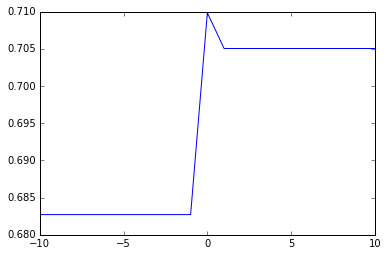

Our optimal C is 1.000000
Our accuracy at optimal C is 0.709850


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# Try testing and plot
c_list = np.logspace(-10,10,21) 
c_index = np.linspace(-10,10,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score,  solver = 'liblinear', max_iter  = 10000, penalty = 'l1')
    cv_scores.append(cross_val_score(lm, X, y,cv = 10, scoring = 'accuracy').mean())

plt.plot(c_index, cv_scores)
plt.show()

print("Our optimal C is %f" %c_list[np.argmax(cv_scores)])   
print("Our accuracy at optimal C is %f" %np.max(cv_scores))
    

In [20]:
lm = LogisticRegression(C = 1,  solver = 'liblinear', max_iter  = 10000, penalty = 'l1')
lm.fit(X,y)
print(lm.coef_)

# We can see that prestige_3 was shrunk to zero

[[ 0.87082998  1.02547448  1.25335171  0.59895604  0.        ]]


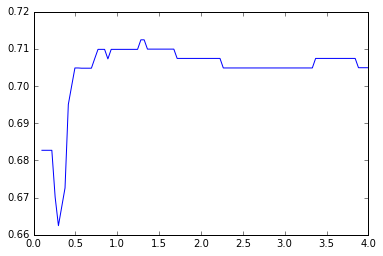

Our optimal C is 1.281818
Our accuracy at optimal C is 0.712414


In [21]:
### You can localize your search once you have an idea of where to search for the optimal solution

c_list = np.linspace(0.1,4,100) 
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score,  solver = 'liblinear', max_iter  = 10000, penalty = 'l1')
    cv_scores.append(cross_val_score(lm, X, y,cv = 10, scoring = 'accuracy').mean())

plt.plot(c_list, cv_scores)
plt.show()

print("Our optimal C is %f" %c_list[np.argmax(cv_scores)])   
print("Our accuracy at optimal C is %f" %np.max(cv_scores))


#### Let's now try l2 penalty using solver = ‘newton-cg’

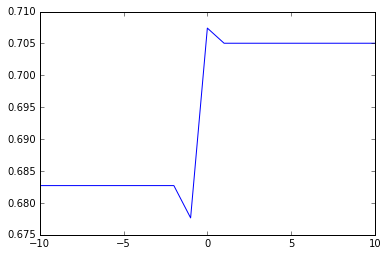

Our optimal C is 1.000000
Our accuracy at optimal C is 0.707414


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
# Try testing and plot
c_list = np.logspace(-10,10,21) 
c_index = np.linspace(-10,10,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score,  solver = 'newton-cg', max_iter  = 10000, penalty = 'l2')
    cv_scores.append(cross_val_score(lm, X, y,cv = 10, scoring = 'accuracy').mean())

plt.plot(c_index, cv_scores)
plt.show()

print("Our optimal C is %f" %c_list[np.argmax(cv_scores)])   
print("Our accuracy at optimal C is %f" %np.max(cv_scores))


In [23]:
lm = LogisticRegression(C = 1,  solver = 'newton-cg', max_iter  = 10000, penalty = 'l2')
lm.fit(X,y)
print(lm.coef_)

[[ 1.03528518  1.12595352  1.2867772   0.66687786  0.0385698 ]]


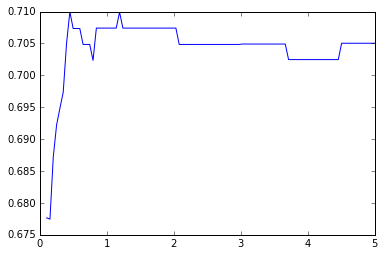

Our optimal C is 0.446465
Our accuracy at optimal C is 0.709975


In [24]:
### Let's localize our seach 
c_list = np.linspace(.1,5,100)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score,  solver = 'newton-cg', max_iter  = 10000, pbenalty = 'l2')
    cv_scores.append(cross_val_score(lm, X, y,cv = 10, scoring = 'accuracy').mean())

plt.plot(c_list, cv_scores)
plt.show()

print("Our optimal C is %f" %c_list[np.argmax(cv_scores)])   
print("Our accuracy at optimal C is %f" %np.max(cv_scores))